# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthday and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [61]:
from datetime import date, datetime, timedelta

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location

> Indented block
> 


Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(-0.11534, 51.49742)
```

In [62]:
# write your solution here


def geocode_location(city, country):
    url = f"https://geocode.xyz/{city},{country}?json=1"               # ? indicated start of query string
    r = requests.get(url)
    # json response
    jr = r.json()
    latt = float(jr['latt'])
    long = float(jr['longt'])
    return long, latt
geocode_location("lexington", "kentucky")

(-84.49056, 38.03693)

## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format

Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

#### HINT: How to insert a screenshot
1. Take a screenshot and save it to a file.
2. Create a markdown cell in your notebook.
3. Insert the image into the markdown cell.
  * Option 1: Drag the image file into the markdown cell. This embeds the image data directly into your Jupyter notebook.
  * Option 2: Move the file into the directory with your notebook file (inside the project folder that you will submit). Add markdown to insert the image: `![alternative text](path-to-image)`

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range


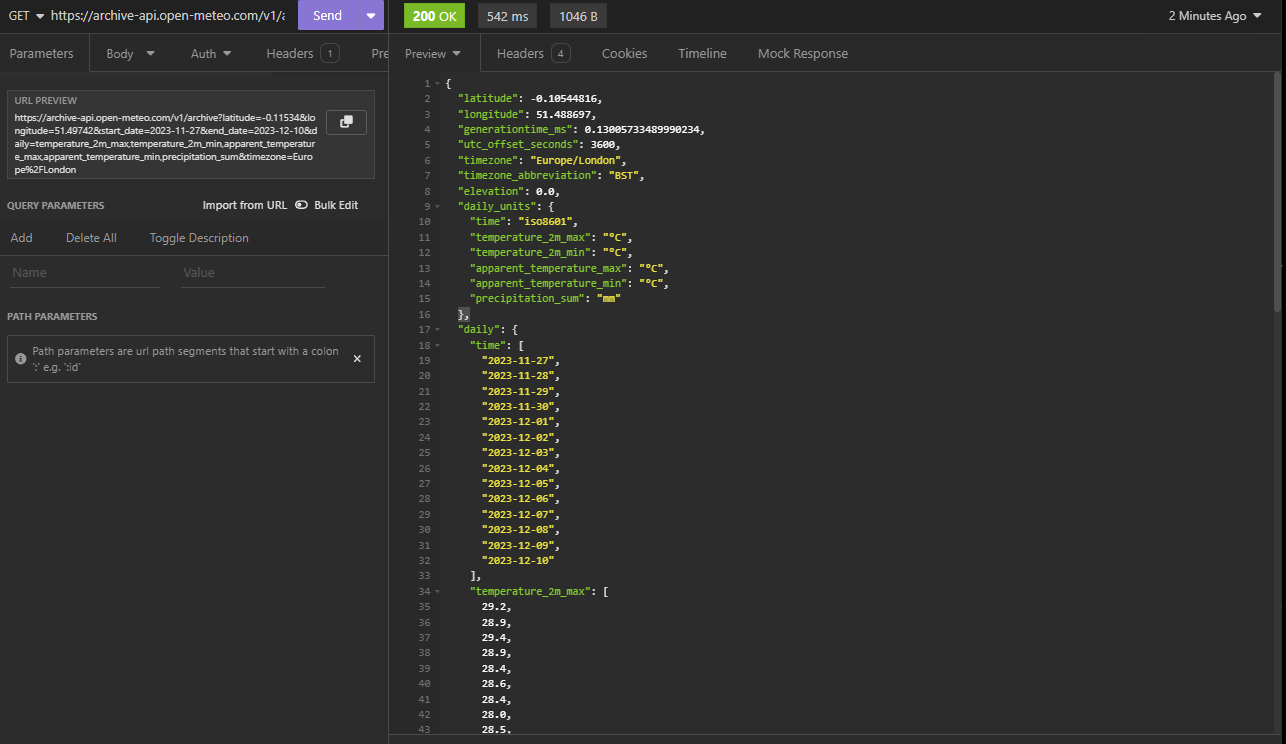

In [65]:
pip install openmeteo-requests

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install requests-cache retry-requests numpy pandas

   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   ------ --------------------------------- 10.2/61.4 kB ? eta -:--:--
   -------------------------- ------------- 41.0/61.4 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 61.4/61.4 kB 544.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
   ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [67]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.49742,
	"longitude": -0.11534,
	"start_date": "2023-11-27",
	"end_date": "2023-12-10",
	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
	"timezone": "Europe/London"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)



Coordinates 51.49384689331055°N -0.16302490234375°E
Elevation 11.0 m asl
Timezone b'Europe/London' b'BST'
Timezone difference to GMT+0 3600 s
                        date  temperature_2m_max  temperature_2m_min  \
0  2023-11-26 23:00:00+00:00            9.734500              5.0345   
1  2023-11-27 23:00:00+00:00            6.634500              0.8345   
2  2023-11-28 23:00:00+00:00            4.384500             -1.0155   
3  2023-11-29 23:00:00+00:00            4.534500             -2.7155   
4  2023-11-30 23:00:00+00:00            4.134500             -2.1155   
5  2023-12-01 23:00:00+00:00           -0.365500             -3.8155   
6  2023-12-02 23:00:00+00:00            7.684500             -0.3155   
7  2023-12-03 23:00:00+00:00            7.934500              5.6845   
8  2023-12-04 23:00:00+00:00            6.334500              3.3845   
9  2023-12-05 23:00:00+00:00            4.434500              0.8345   
10 2023-12-06 23:00:00+00:00            8.284500              4.13

In [63]:
# helper function for 15-day date range
from datetime import datetime, timedelta

def get_date_range(birthday):
    date = datetime.strptime(birthday, "%Y-%m-%d")
    start_date = (date - timedelta(days=7)).strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=7)).strftime("%Y-%m-%d")
    birthday = '12/03/2000'
    return {'start_date': birthday - timedelta(days=7),
            'end_date': birthday + timedelta(days=7)
           }

SyntaxError: incomplete input (376640158.py, line 2)

In [ ]:
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"


In [58]:
# write your solution here
def get_api_response(latitude, longitude, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": "2023-11-27",
    	"end_date": "2023-12-10",
    	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
    	"timezone": "Europe/London"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        api_data = response.json
        return{
            'latitude':api_data['latitude']}
    else:
        return None

In [56]:
# write your solution here
def get_api_response(latitude, longitude, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": "2023-11-27",
    	"end_date": "2023-12-10",
    	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
    	"timezone": "Europe/London"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        api_data = response.json
        return{
            'latitude':api_data['latitude']}
    else:
        return None

In [53]:
url = 'https://archive-api.open-meteo.com/v1/archive?latitude=51.49742&longitude=-0.11534&start_date=2023-11-27&end_date=2023-12-10&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum&timezone=Europe%2FLondon'
r = requests.get(url)
jr = r.json()
jr

{'latitude': 51.493847,
 'longitude': -0.1630249,
 'generationtime_ms': 0.1289844512939453,
 'utc_offset_seconds': 3600,
 'timezone': 'Europe/London',
 'timezone_abbreviation': 'BST',
 'elevation': 11.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_max': '°C',
  'temperature_2m_min': '°C',
  'apparent_temperature_max': '°C',
  'apparent_temperature_min': '°C',
  'precipitation_sum': 'mm'},
 'daily': {'time': ['2023-11-27',
   '2023-11-28',
   '2023-11-29',
   '2023-11-30',
   '2023-12-01',
   '2023-12-02',
   '2023-12-03',
   '2023-12-04',
   '2023-12-05',
   '2023-12-06',
   '2023-12-07',
   '2023-12-08',
   '2023-12-09',
   '2023-12-10'],
  'temperature_2m_max': [9.7,
   6.6,
   4.4,
   4.5,
   4.1,
   -0.4,
   7.7,
   7.9,
   6.3,
   4.4,
   8.3,
   10.9,
   13.9,
   11.8],
  'temperature_2m_min': [5.0,
   0.8,
   -1.0,
   -2.7,
   -2.1,
   -3.8,
   -0.3,
   5.7,
   3.4,
   0.8,
   4.1,
   5.6,
   7.4,
   7.0],
  'apparent_temperature_max': [7.5,
   3.4,
   1.6,
   0.0,
   

### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [ ]:
# write your solution here
def get_all_response_objects(latitude, longitude, date):
    pass # remove this line once you start adding code to your function

### Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [ ]:
# write your solution here
def parse_json_response(responses):
    pass # remove this line once you start adding code to your function

### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthday and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthday = get_user_birthday()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthday and location input information:

In [ ]:
# helper functions
def get_user_birthday():
    birthday = input('Enter your birthday (MM/DD/YYYY): ')
    return datetime.strptime(birthday, "%m/%d/%Y")

def get_user_city_of_birth():
    city = input('Enter the city you were born in: ')
    country = input('Enter the country you were born in: ')
    return city , country

In [ ]:
# write your solution here
def get_data():
    pass # remove this line once you start adding code to your function

Run your function and set it equal to `df`:

In [ ]:
df = get_data()

df.head()

## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

In [ ]:
# enter your code here

### Results Summary: